In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [46]:
rice_dataset_path = '/content/drive/MyDrive/Rice leaf detection'

# Code to identify immediate subfolders in the main dataset path
import os

subfolders = []
for entry in os.listdir(rice_dataset_path):
    full_path = os.path.join(rice_dataset_path, entry)
    if os.path.isdir(full_path):
        subfolders.append(entry)

print(f"Identified subfolders in main folder: {subfolders}")

dataset_subfolder_path = os.path.join(rice_dataset_path, subfolders[0])

classes = []
for entry in os.listdir(dataset_subfolder_path):
    full_path = os.path.join(dataset_subfolder_path, entry)
    if os.path.isdir(full_path):
        classes.append(entry)

print(f"Folders in subfolder : {classes}")

Identified subfolders in main folder: ['rice leaf diseases dataset']
Folders in subfolder : ['Leafsmut', 'Brownspot', 'Bacterialblight']


In [5]:
# Code to count total images in the dataset

image_count = 0
image_extensions = ('.png', '.jpg', '.jpeg') # Define image extensions if not already defined

for root, _, files in os.walk(rice_dataset_path):
    for file in files:
        _, ext = os.path.splitext(file)
        if ext.lower() in image_extensions:
            image_count += 1

print(f"Total images found in the dataset: {image_count}")

Total images found in the dataset: 4684


In [49]:

def display_sample_images(class_name, class_dir_path, num_images=3):
    """
    Displays a specified number of sample images for a given class.

    Args:
        class_name (str): The name of the class.
        class_dir_path (str): The path to the directory containing images for the class.
        num_images (int): The number of sample images to display.
    """
    print(f"Displaying {num_images} sample images for class: {class_name}")

    all_files = os.listdir(class_dir_path)

    image_files = [
        f for f in all_files
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    if len(image_files) == 0:
        print(f"No image files found in {class_dir_path}")
        return

    actual_num_images = min(num_images, len(image_files))

    selected_images = random.sample(image_files, actual_num_images)

    fig, axes = plt.subplots(1, actual_num_images, figsize=(3 * actual_num_images, 3)) # Slightly enlarged figsize
    if actual_num_images == 1:
        axes = [axes] # Ensure axes is iterable even for a single image

    for i, img_file in enumerate(selected_images):
        full_img_path = os.path.join(class_dir_path, img_file)
        try:
            img = Image.open(full_img_path)
            axes[i].imshow(img)
            axes[i].set_title(class_name)
            axes[i].axis('off')
        except Exception as e:
            print(f"Could not load image {img_file}: {e}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Displaying 4 sample images for class: Leafsmut


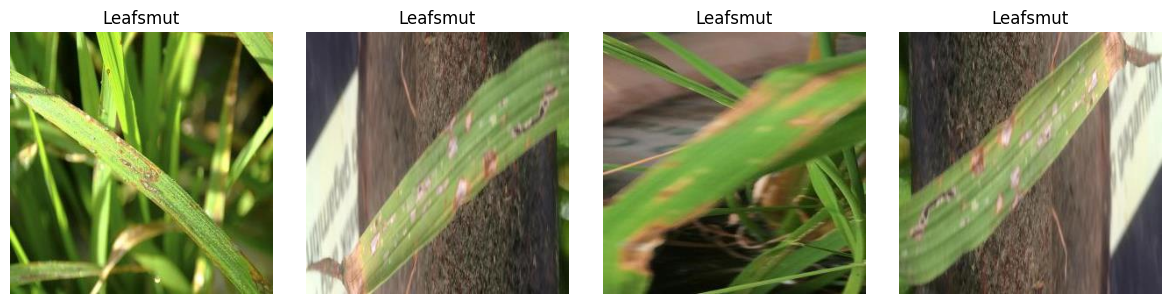

Displaying 4 sample images for class: Brownspot


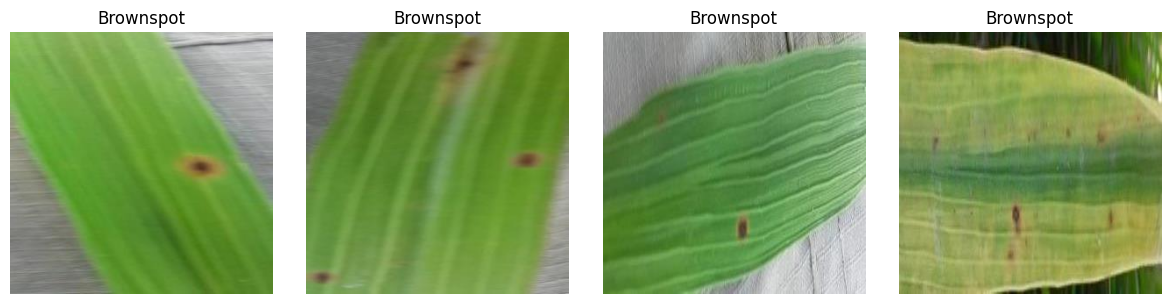

Displaying 4 sample images for class: Bacterialblight


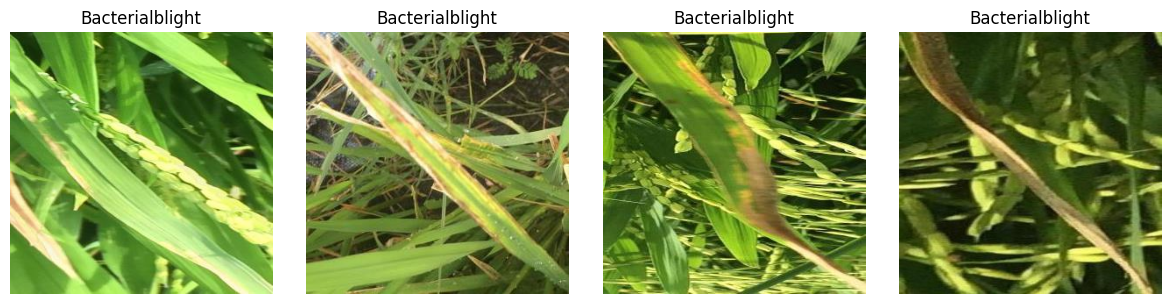

In [50]:
for class_name in classes:
    class_dir_path = os.path.join(dataset_subfolder_path, class_name)
    display_sample_images(class_name, class_dir_path, num_images=4) # Changed num_images to 4

In [23]:

# 1. Define the target image dimensions and batch size
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

print(f"Target image dimensions: {IMG_WIDTH}x{IMG_HEIGHT}")
# print(f"Batch size: {BATCH_SIZE}")

# 3. Use tf.keras.utils.image_dataset_from_directory to load the images
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_subfolder_path,
    labels='inferred',
    label_mode='categorical', # For one-hot encoded labels
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# 4. Create a normalization function
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# 5. Apply this normalization function to the loaded dataset
normalized_dataset = dataset.map(normalize_img)

class_names = dataset.class_names
print("Images loaded and preprocessed successfully.")

Target image dimensions: 224x224
Found 4684 files belonging to 3 classes.
Images loaded and preprocessed successfully.


In [9]:

# 1. Determine the total number of batches
total_batches = math.ceil(image_count / BATCH_SIZE)
print(f"Total batches in the dataset: {total_batches}")

# 2. Calculate the number of batches for training and validation sets
train_batches = int(total_batches * 0.7)
val_batches = total_batches - train_batches

print(f"Training batches: {train_batches}")
print(f"Validation batches: {val_batches}")

# 3. Create the training dataset
train_ds = normalized_dataset.take(train_batches)

# 4. Create the validation dataset
val_ds = normalized_dataset.skip(train_batches).take(val_batches)

# 5. Optimize both datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset split into training and validation sets, and optimized successfully.")


Total batches in the dataset: 147
Training batches: 102
Validation batches: 45
Dataset split into training and validation sets, and optimized successfully.


In [11]:

# 1. Determine the number of classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# 2. Create a Sequential model instance
model = Sequential([
    # Input layer
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block (optional, but good for deeper features)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output for the Dense layers
    Flatten(),

    # Dense layers for classification
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout to prevent overfitting

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Print the model summary to verify the architecture
model.summary()
print("CNN model architecture defined successfully.")

Number of classes: 3


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture defined successfully.


In [12]:
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully with Adam optimizer, categorical cross-entropy loss, and accuracy metric.")

Model compiled successfully with Adam optimizer, categorical cross-entropy loss, and accuracy metric.


In [24]:
epochs = 15
print(f"Training for {epochs} epochs.")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("Model training complete.")

Training for 15 epochs.
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9894 - loss: 0.0426 - val_accuracy: 0.9585 - val_loss: 0.1274
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9883 - loss: 0.0373 - val_accuracy: 0.9725 - val_loss: 0.1030
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9931 - loss: 0.0232 - val_accuracy: 0.9810 - val_loss: 0.0992
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9868 - loss: 0.0472 - val_accuracy: 0.9754 - val_loss: 0.1125
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9832 - loss: 0.0415 - val_accuracy: 0.9775 - val_loss: 0.1004
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9937 - loss: 0.0223 - val_accuracy: 0.9775 - val_loss: 0.0878
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9893 - loss: 0.0314 - val_accuracy: 0.9479 - val_loss: 0.1839
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9842 

In [25]:
print("Evaluating model performance on the validation set...")
loss, accuracy = model.evaluate(val_ds)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating model performance on the validation set...
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9819 - loss: 0.0621
Validation Loss: 0.0801
Validation Accuracy: 0.9817


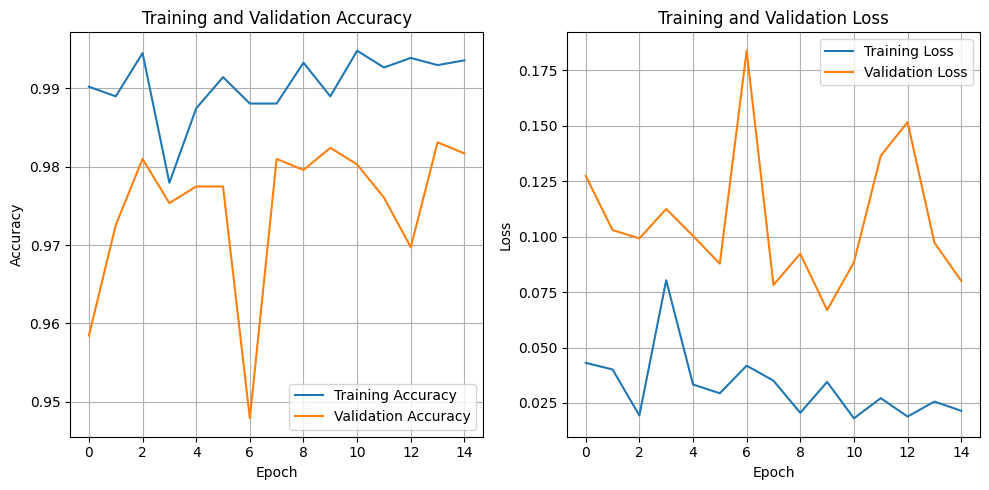

Training and validation accuracy/loss plots generated.


In [32]:

# Get training and validation metrics from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

print("Training and validation accuracy/loss plots generated.")

Displaying 15 sample images from the validation set.


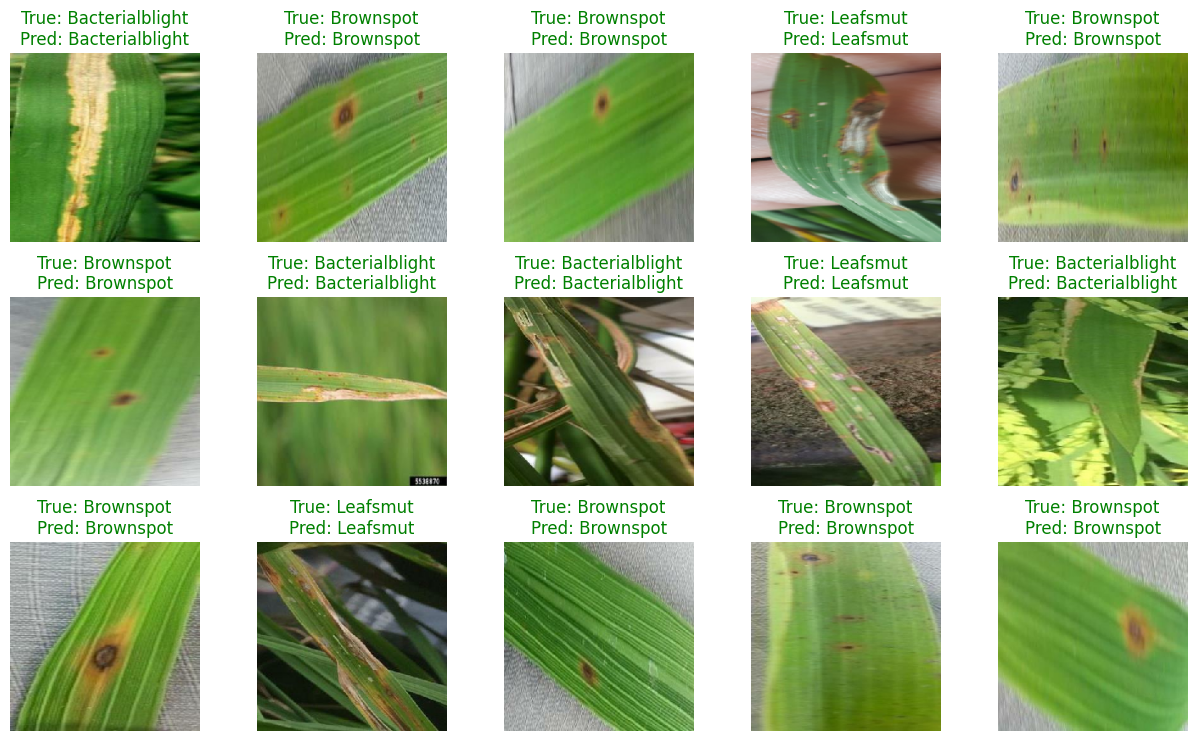

Sample predictions displayed successfully.


In [37]:

# Define the number of images to display
num_images_to_display = 15

print(f"Displaying {num_images_to_display} sample images from the validation set.")

# Get one batch from the validation dataset
images, true_labels = next(iter(val_ds))

# Make predictions using the trained model
predictions = model.predict(images, verbose=0)

# Determine the number of images to display, up to num_images_to_display
actual_num_images_to_display = min(num_images_to_display, images.shape[0])

# Calculate rows and columns for subplot grid, max 5 columns
cols = 5
rows = (actual_num_images_to_display + cols - 1) // cols

plt.figure(figsize=(cols * 2.5, rows * 2.5)) # Slightly enlarged figsize

for i in range(actual_num_images_to_display):
    plt.subplot(rows, cols, i + 1)

    # a. Convert the image tensor to a NumPy array and scale it back to 0-255
    image_display = (images[i].numpy() * 255).astype(np.uint8)

    # b. Determine the true class label
    true_label_idx = np.argmax(true_labels[i].numpy())
    true_label_name = class_names[true_label_idx]

    # c. Determine the predicted class label
    predicted_label_idx = np.argmax(predictions[i])
    predicted_label_name = class_names[predicted_label_idx]

    # d. Display the image
    plt.imshow(image_display)

    # e. Set the title of the subplot
    color = 'green' if true_label_idx == predicted_label_idx else 'red'
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color=color)

    # f. Turn off the axis
    plt.axis('off')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

print("Sample predictions displayed successfully.")

In [17]:
# Initialize lists to store true labels and predictions
all_true_labels = []
all_predictions = []

print("Collecting true labels and making predictions for the entire validation set...")

# Iterate over the validation dataset to collect true labels and make predictions
for images, labels in val_ds:
    # Append true labels (convert from one-hot to class index)
    all_true_labels.extend(np.argmax(labels.numpy(), axis=1))

    # Get model predictions and append (convert from probabilities to class index)
    preds = model.predict(images, verbose=0)
    all_predictions.extend(np.argmax(preds, axis=1))

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predictions = np.array(all_predictions)

print("True labels and predictions collected successfully.")
print(f"Total true labels collected: {len(all_true_labels)}")
print(f"Total predictions collected: {len(all_predictions)}")

True labels and predictions collected successfully.
Total true labels collected: 1420
Total predictions collected: 1420


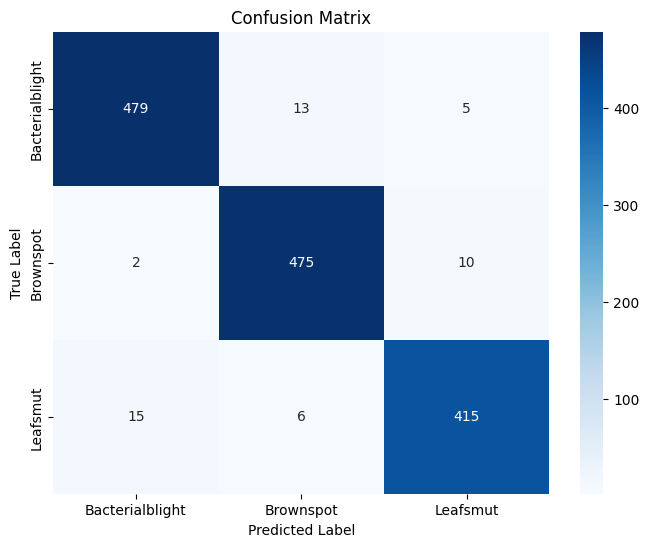

Confusion matrix generated and displayed successfully.


In [28]:

# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion matrix generated and displayed successfully.")